In [499]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from PIL import ImageFile
from keras.preprocessing import image                  
from tqdm import tqdm
from datetime import datetime
import  matplotlib.pyplot as plt
%matplotlib inline

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as preprocess_input_vgg19
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import Sequential


In [484]:
def load_dataset(path, random_state = 0):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 120)
    return dog_files, dog_targets

train_files, train_targets = load_dataset('./train')
test_files, test_targets = load_dataset('./test')

dog_names = [item for item in sorted(glob("./train/*/"))]

# Let's check the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d test dog images.'% len(test_files))


There are 120 total dog categories.
There are 10222 total dog images.

There are 8177 training dog images.
There are 2045 test dog images.


In [16]:
# preprocessing 

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size = (224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis = 0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


In [17]:
                      
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255


100%|██████████| 2045/2045 [00:08<00:00, 252.48it/s]


In [19]:
# transfer learning with pretrained model 

def extract_VGG19(file_paths):
    tensors = paths_to_tensor(file_paths).astype('float32')
    preprocessed_input = preprocess_input_vgg19(tensors)
    return VGG19(weights ='imagenet', include_top = False).predict(preprocessed_input, batch_size = 32)



In [20]:
train_vgg19 = extract_VGG19(train_files)
test_vgg19 = extract_VGG19(test_files)

print("VGG19 shape", train_vgg19.shape[1:])


100%|██████████| 8177/8177 [00:36<00:00, 221.94it/s]


80142336/80134624 [==============================] - 62s 1us/step


100%|██████████| 2045/2045 [00:09<00:00, 222.55it/s]


VGG19 shape (7, 7, 512)


In [21]:
# save extracted features 

np.save('auto_train.npy', train_vgg19)
np.save('auto_test.npy', test_vgg19)


In [71]:
# classification layer for extracted features 

new_model = Sequential()
new_model.add(GlobalAveragePooling2D(input_shape = train_vgg19.shape[1:]))
new_model.add(Dense(256))
new_model.add(Dropout(0.3))
new_model.add(Dense(120, activation = 'softmax'))

# new_model.summary()


In [67]:

# model compile 
optimizer = 'adam'
new_model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

batch_size = 64
epochs = 60

# logs are different runs are saved in different subfolders 
now = datetime.now()
log_dir = "./graph/" + now.strftime("%Y%m%d-%H%M%S") + "/"
# tensorboard
tb = TensorBoard(log_dir = log_dir, histogram_freq = 0, write_graph = True, write_images = True)

checkpointer = ModelCheckpoint(filepath = 'saved_models/bestmodel.hdf5', verbose = 1, save_best_only = True)

# model fitting without data augmentation 
history = new_model.fit(train_vgg19, train_targets, 
          validation_data = (test_vgg19, test_targets),
          epochs = epochs, batch_size = batch_size, callbacks = [checkpointer, tb], verbose = 1)


Train on 8177 samples, validate on 2045 samples
Epoch 1/60
8177/8177 [==============================] - 1s 117us/step - loss: 11.3854 - acc: 0.1562 - val_loss: 7.6283 - val_acc: 0.3350

Epoch 00001: val_loss improved from inf to 7.62834, saving model to saved_models/bestmodel.hdf5
Epoch 2/60
8177/8177 [==============================] - 1s 106us/step - loss: 6.4691 - acc: 0.4015 - val_loss: 4.5174 - val_acc: 0.5007

Epoch 00002: val_loss improved from 7.62834 to 4.51744, saving model to saved_models/bestmodel.hdf5
Epoch 3/60
8177/8177 [==============================] - 1s 128us/step - loss: 4.1598 - acc: 0.5489 - val_loss: 3.6327 - val_acc: 0.5697

Epoch 00003: val_loss improved from 4.51744 to 3.63270, saving model to saved_models/bestmodel.hdf5
Epoch 4/60
8177/8177 [==============================] - 1s 123us/step - loss: 3.1643 - acc: 0.6250 - val_loss: 3.4037 - val_acc: 0.6005

Epoch 00004: val_loss improved from 3.63270 to 3.40372, saving model to saved_models/bestmodel.hdf5
Epoch 5


Epoch 00041: val_loss did not improve from 2.54391
Epoch 42/60
8177/8177 [==============================] - 1s 99us/step - loss: 0.4944 - acc: 0.9155 - val_loss: 3.5636 - val_acc: 0.6377

Epoch 00042: val_loss did not improve from 2.54391
Epoch 43/60
8177/8177 [==============================] - 1s 99us/step - loss: 0.5024 - acc: 0.9130 - val_loss: 3.4296 - val_acc: 0.6513

Epoch 00043: val_loss did not improve from 2.54391
Epoch 44/60
8177/8177 [==============================] - 1s 105us/step - loss: 0.4676 - acc: 0.9170 - val_loss: 3.5887 - val_acc: 0.6352

Epoch 00044: val_loss did not improve from 2.54391
Epoch 45/60
8177/8177 [==============================] - 1s 102us/step - loss: 0.4577 - acc: 0.9199 - val_loss: 3.6101 - val_acc: 0.6396

Epoch 00045: val_loss did not improve from 2.54391
Epoch 46/60
8177/8177 [==============================] - 1s 121us/step - loss: 0.4929 - acc: 0.9162 - val_loss: 3.4823 - val_acc: 0.6577

Epoch 00046: val_loss did not improve from 2.54391
Epoch

In [318]:
# load the best model and check testing accuracy

new_model.load_weights('saved_models/bestmodel.hdf5')

# Calculate classification accuracy on the test dataset.
pred = np.argmax(new_model.predict(test_vgg19), axis =1)
# prediction probabilities 
prob = np.max(new_model.predict(test_vgg19), aixs = 1)

# Report test accuracy
test_accuracy = 100* np.sum(np.array(newmodel_pred) == np.argmax(test_targets, axis = 1))/len(newmodel_pred)
print('Test accuracy: %.4f%%' % test_accuracy)


Test accuracy: 66.1614%


In [450]:
# true labels in numerical value
truth = np.argmax(test_targets, axis = 1)

# wrongly classified images 
errors = (pred - truth != 0 )

# predicted labels for those that are predicted wrong 
pred_errors = np.array(pred)[errors]
# true lable for those that are predicted wrong 
truth_errors = truth[errors] 
# prediction probability of the wrong classes  
prob_errors = np.array(prob)[errors]

# images that are classified wrognly 
image_errors = test_files[errors]

# most wrongly classified images are those that are wrong but with high prediction probabilities
top5_index = np.argsort(- np.array(prob_errors))[: 5]


In [481]:
# for the most wrongly classified images 

pred_label = pred_errors[top5_index]
pred_breed = [dog_names[i].split('/')[2] for i in pred_label]
pred_prob = prob_errors[top5_index]

true_label = truth_errors[top5_index]
true_breed = [dog_names[i].split('/')[2] for i in true_label]


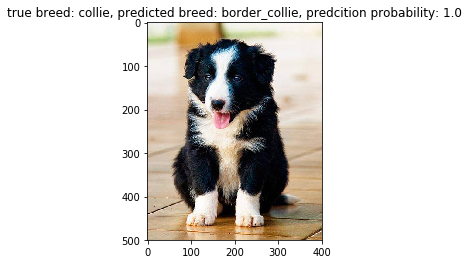

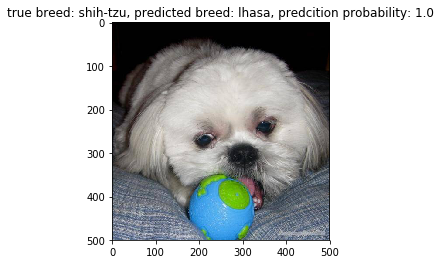

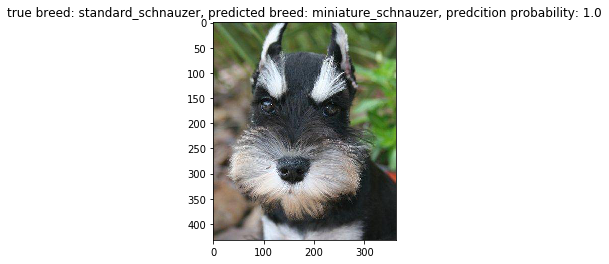

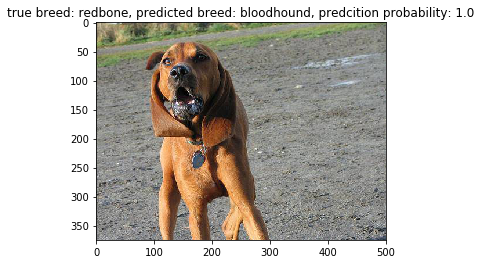

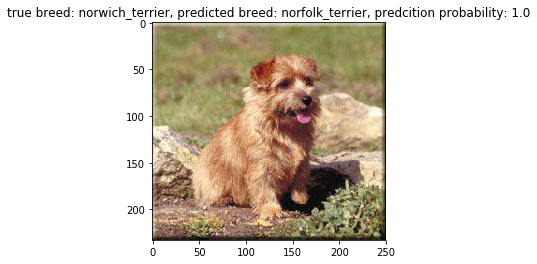

In [507]:
# the most wrongly classified image, prediction, true label

for i in range(len(test_files[top5_index])):
    # read image file 
    file = image_errors[top5_index][i]

    img = image.load_img(file)
    plt.figure()
    plt.imshow(img)
    plt.title('true breed: {}, predicted breed: {}, predcition probability: {}'.format(true_breed[i], pred_breed[i], pred_prob[i]))
 
